In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Ответы и вывод доступны в самом низу ноутбука

## Загрузка датасета

In [2]:
# Редактирую ссылку на Google Drive, чтобы загрузить excel 

url = 'https://docs.google.com/spreadsheets/d/1L8843A80r50_e-hU79XV_ssAfzgQVUDP/edit#gid=53539924'

url2 = url.replace('/edit#gid=', '/export?format=csv&gid=')

In [3]:
# Загружаю данные

df = pd.read_csv(url2, parse_dates=['purchase_date'])

## Предварительный анализ датасета

In [4]:
# Изучаю датасет

In [5]:
df.head()

,product_id,quantity,is_trial_period,purchase_date,user_id
0,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-19,9484222
1,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-17,9422402
2,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-18,4997991
3,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-18,9455582
4,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-16,8803657


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114200 entries, 0 to 114199
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   product_id       114200 non-null  object        
 1   quantity         114200 non-null  int64         
 2   is_trial_period  114200 non-null  bool          
 3   purchase_date    114200 non-null  datetime64[ns]
 4   user_id          114200 non-null  int64         
dtypes: bool(1), datetime64[ns](1), int64(2), object(1)
memory usage: 3.6+ MB


In [7]:
df[['product_id', 'quantity', 'is_trial_period']].value_counts()

product_id                               quantity  is_trial_period
1week_4.99_USD_subscription_7days_trial  1         True               63008
                                                   False              51192
dtype: int64

In [8]:
# Проверяю есть ли дубли

df[df.duplicated()].value_counts()

product_id                               quantity  is_trial_period  purchase_date  user_id
1week_4.99_USD_subscription_7days_trial  1         False            2020-02-16     9584301    6
                                                                    2020-01-22     8671902    2
                                                   True             2020-01-08     8450482    2
                                                                    2020-01-09     8486473    2
                                                                    2020-01-23     8928229    2
                                                                                             ..
                                                                    2020-01-14     8650192    1
                                                                                   8657144    1
                                                                    2020-01-15     8670525    1
                                             

In [9]:
# Проверяю количество дублей

print('Кол-во дублей: ', df[df.duplicated()].value_counts().sum())

print('Доля дублей: ', round((df[df.duplicated()].value_counts().sum() / df.product_id.count() * 100), 3))

Кол-во дублей:  84
Доля дублей:  0.074


## Подготовка датасета для дальнейших расчётов

In [10]:
# В данных присутствуют дубли, предполагаю, что несколько триалов/покупок в одну и ту же дату
# для 1 юзера - это скорее задублированные данные, чем поведение юзера -> дропаю их
# Т.к. дублей очень мало, даже если это особенность поведения юзера, на дальнейшие расчёты существенного влияния не окажет

df2 = df.drop_duplicates()

In [11]:
# Проверяю есть ли случаи, когда юзер оформлял больше 1 триала в разные дни

df2[df2.is_trial_period==True].groupby('user_id').is_trial_period.count().sort_values(ascending = False)

user_id
8796120    2
5627786    2
8498380    2
9287947    2
8311720    2
          ..
8636348    1
8636357    1
8636368    1
8636375    1
9694775    1
Name: is_trial_period, Length: 62909, dtype: int64

In [12]:
# Часть юзеров оформляли пробную подписку несколько раз в разные дни, как обрабатывать такие случаи? 
# Буду вести отсчёт с самой ранней триальной подписки, считая что за одного и того же юзера заплатили только 1 раз

# Добавляю столбец с датой самой ранней триальной подписки юзера, чтобы пересчитать даты покупок относительно даты триала

df2['earliest_purchase_date'] = df2.groupby(['user_id']).purchase_date.transform('min')

<ipython-input-12-7de709142451>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['earliest_purchase_date'] = df2.groupby(['user_id']).purchase_date.transform('min')


In [13]:
# Добавляю номер недели в которую произошло событие относительно даты самой ранней триальной подписки юзера

df2['weeks_sinse_trial'] = np.ceil((df2.purchase_date - df2.earliest_purchase_date).dt.days.astype(int) / 7).astype(int)

<ipython-input-13-e88eeeaf72d6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['weeks_sinse_trial'] = np.ceil((df2.purchase_date - df2.earliest_purchase_date).dt.days.astype(int) / 7).astype(int)


In [14]:
# Добавляю столбец с ценой подписки для удобства подсчёта, $0 для is_triaL_period = True, $4.99 для is_triaL_period = False

df2['revenue'] = np.where(df2.is_trial_period == False, 4.99, 0)

<ipython-input-14-70c0d256bb17>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['revenue'] = np.where(df2.is_trial_period == False, 4.99, 0)


In [15]:
# Добавляю столбец с когортами к которым относится каждый юзер. 
# Номер когорты = количество событий совершенных юзером (кол-во триалов + кол-во оплат)

df2['cohort'] = df2.groupby(['user_id']).quantity.transform('count')

<ipython-input-15-d98fa50cef61>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['cohort'] = df2.groupby(['user_id']).quantity.transform('count')


In [16]:
df2[df2.weeks_sinse_trial==7].purchase_date.value_counts()

2020-02-19    184
2020-02-20     82
2020-02-18     50
2020-02-17     36
2020-02-15     30
2020-02-16     24
2020-02-14     24
2020-02-13      8
Name: purchase_date, dtype: int64

## 1. Рассчёт текущего LTV юзера, используя когортный анализ

In [17]:
# Как я понимаю, в этом пункте хочется получить LTV в виде одной цифры, т.е. не на какую-то дату (например на третью неделю)

# Рассчитаем выруску накопительным итогом по когортам, затем рахделим на кол-во юзеров в когорте,
# таким образом получим LTV юзера в когорте

# Далее посчитаем среднее взвешанное LTV по когортам

In [18]:
# Выручка накопительным итогом
cumsum_revenue_pivot = df2.pivot_table(index = ['cohort'], columns = ['weeks_sinse_trial'], values = ['revenue'], aggfunc = 'sum').cumsum(axis=1)

# NaN заполним по строкам
cumsum_revenue_pivot_nona = cumsum_revenue_pivot.fillna(method='ffill', axis=1)

In [19]:
cumsum_revenue_pivot

revenue                                                    \
weeks_sinse_trial       0         1         2         3         4         5   
cohort                                                                        
1                    0.00       NaN       NaN       NaN       NaN       NaN   
2                    9.98  29645.59  32869.13  34136.59  34925.01  35588.68   
3                    0.00  17629.67  35289.28  37894.06  39196.45  39939.96   
4                    9.98  12045.86  24286.33  36656.54  38887.07  39885.07   
5                    4.99  10089.78  20114.69  30309.26  40578.68  42270.29   
6                    4.99   8468.03  17000.93  25458.98  33966.93  42554.72   
7                    9.98   7320.33  14625.69  21970.97  29276.33  36611.63   
8                    4.99   1042.91   2075.84   3113.76   4151.68   5179.62   

                                                 
weeks_sinse_trial         6         7         8  
cohort                                           
1                       NaN       NaN       NaN  
2                  35818.22  35883.09       NaN  
3                  40214.41  40299.24       NaN  
4                  40344.15  40438.96       NaN  
5                  42993.84  43208.41  43213.40  
6                  43627.57  43827.17  43832.16  
7                  43936.95  44415.99       NaN  
8                   6217.54   7255.46   7265.44

In [20]:
cumsum_revenue_pivot_nona

revenue                                                    \
weeks_sinse_trial       0         1         2         3         4         5   
cohort                                                                        
1                    0.00      0.00      0.00      0.00      0.00      0.00   
2                    9.98  29645.59  32869.13  34136.59  34925.01  35588.68   
3                    0.00  17629.67  35289.28  37894.06  39196.45  39939.96   
4                    9.98  12045.86  24286.33  36656.54  38887.07  39885.07   
5                    4.99  10089.78  20114.69  30309.26  40578.68  42270.29   
6                    4.99   8468.03  17000.93  25458.98  33966.93  42554.72   
7                    9.98   7320.33  14625.69  21970.97  29276.33  36611.63   
8                    4.99   1042.91   2075.84   3113.76   4151.68   5179.62   

                                                 
weeks_sinse_trial         6         7         8  
cohort                                           
1                      0.00      0.00      0.00  
2                  35818.22  35883.09  35883.09  
3                  40214.41  40299.24  40299.24  
4                  40344.15  40438.96  40438.96  
5                  42993.84  43208.41  43213.40  
6                  43627.57  43827.17  43832.16  
7                  43936.95  44415.99  44415.99  
8                   6217.54   7255.46   7265.44

In [21]:
#Кол-во юзеров совершивших действия в каждую отдельную неделю по когортам

unique_users_count_pivot = df2.pivot_table(index = ['cohort'], columns = ['weeks_sinse_trial'], values = 'user_id', aggfunc = pd.Series.nunique)

In [22]:
unique_users_count_pivot

weeks_sinse_trial,0,1,2,3,4,5,6,7,8
cohort,,,,,,,,,
1,43336.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,7218.0,5963.0,648.0,255.0,158.0,133.0,46.0,14.0,NaN
3,4039.0,3533.0,3539.0,522.0,261.0,149.0,55.0,17.0,NaN
4,2702.0,2412.0,2453.0,2480.0,447.0,199.0,92.0,19.0,NaN
5,2165.0,2021.0,2009.0,2043.0,2058.0,340.0,145.0,43.0,1.0
6,1757.0,1696.0,1710.0,1695.0,1705.0,1721.0,215.0,40.0,1.0
7,1484.0,1465.0,1464.0,1472.0,1465.0,1470.0,1468.0,97.0,NaN
8,208.0,208.0,207.0,208.0,208.0,207.0,208.0,208.0,2.0


In [23]:
# Добавляю столец с кол-вом юзеров

cumsum_revenue_n_users_qty = pd.concat([cumsum_revenue_pivot_nona, unique_users_count_pivot.iloc[:,0].rename('user_qty')], axis=1)

In [24]:
# Считаю LTV юзера по когортам

cumsum_revenue_n_users_qty['Avg_cohort_user_LTV'] = cumsum_revenue_n_users_qty[('revenue', 8)] / cumsum_revenue_n_users_qty['user_qty']

In [25]:
cumsum_revenue_n_users_qty

,"(revenue, 0)","(revenue, 1)","(revenue, 2)","(revenue, 3)","(revenue, 4)","(revenue, 5)","(revenue, 6)","(revenue, 7)","(revenue, 8)",user_qty,Avg_cohort_user_LTV
cohort,,,,,,,,,,,
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,43336.0,0.000000
2,9.98,29645.59,32869.13,34136.59,34925.01,35588.68,35818.22,35883.09,35883.09,7218.0,4.971334
3,0.00,17629.67,35289.28,37894.06,39196.45,39939.96,40214.41,40299.24,40299.24,4039.0,9.977529
4,9.98,12045.86,24286.33,36656.54,38887.07,39885.07,40344.15,40438.96,40438.96,2702.0,14.966306
5,4.99,10089.78,20114.69,30309.26,40578.68,42270.29,42993.84,43208.41,43213.40,2165.0,19.960000
6,4.99,8468.03,17000.93,25458.98,33966.93,42554.72,43627.57,43827.17,43832.16,1757.0,24.947160
7,9.98,7320.33,14625.69,21970.97,29276.33,36611.63,43936.95,44415.99,44415.99,1484.0,29.929912
8,4.99,1042.91,2075.84,3113.76,4151.68,5179.62,6217.54,7255.46,7265.44,208.0,34.930000


In [26]:
# Считаю LTV как среднее взвешанное по когортам

In [27]:
LTV_current = np.average(cumsum_revenue_n_users_qty['Avg_cohort_user_LTV'], weights=cumsum_revenue_n_users_qty['user_qty'])

In [28]:
# Так как нет вводных данных про Gross Margin и discount rate, считаю LTV через revenue

print('Текущий LTV юзера, $: ', round(LTV_current,3))

Текущий LTV юзера, $:  4.059


## 2. Спрогнозировать, каким будет LTV на полгода

In [29]:
# Прогнозировать LTV буду через прогнозирование retention curve в форме y = a * x^b с помощью регрессии
# Далее посчитаю LTV как ARPWAU * Retention накопительным итогом
# Полгода - это 52/2 = 26 weeks

In [30]:
# Цена 1 подписки
ARPWAU = 4.99

In [31]:
unique_users_count_pivot

weeks_sinse_trial,0,1,2,3,4,5,6,7,8
cohort,,,,,,,,,
1,43336.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,7218.0,5963.0,648.0,255.0,158.0,133.0,46.0,14.0,NaN
3,4039.0,3533.0,3539.0,522.0,261.0,149.0,55.0,17.0,NaN
4,2702.0,2412.0,2453.0,2480.0,447.0,199.0,92.0,19.0,NaN
5,2165.0,2021.0,2009.0,2043.0,2058.0,340.0,145.0,43.0,1.0
6,1757.0,1696.0,1710.0,1695.0,1705.0,1721.0,215.0,40.0,1.0
7,1484.0,1465.0,1464.0,1472.0,1465.0,1470.0,1468.0,97.0,NaN
8,208.0,208.0,207.0,208.0,208.0,207.0,208.0,208.0,2.0


In [32]:
# Видим,что в восьмую неделю относительно старта в когортах 
# очень мало юзеров, это связано с тем, что датасет собран до определённой даты - 2020-02-20
# Поэтому прогнозировать retention curve буду на основе 0-7 недель

In [33]:
df2[df2.weeks_sinse_trial==4].purchase_date.value_counts()

2020-01-31    378
2020-01-30    360
2020-02-01    345
2020-02-13    340
2020-02-02    329
2020-02-12    312
2020-02-14    293
2020-02-07    280
2020-02-05    276
2020-02-03    273
2020-02-10    270
2020-02-08    269
2020-02-11    263
2020-02-04    263
2020-02-06    263
2020-01-29    245
2020-02-19    236
2020-02-09    228
2020-02-15    218
2020-02-18    216
2020-02-17    213
2020-02-16    209
2020-02-20     76
2020-01-28     41
2020-01-27     34
2020-01-26     24
2020-01-25     22
2020-01-24     14
2020-01-23     12
Name: purchase_date, dtype: int64

In [34]:
unique_users_count_pivot_7weeks = unique_users_count_pivot.drop([8], axis=1).fillna(0)

In [35]:
unique_users_count_pivot_7weeks

weeks_sinse_trial,0,1,2,3,4,5,6,7
cohort,,,,,,,,
1,43336.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,7218.0,5963.0,648.0,255.0,158.0,133.0,46.0,14.0
3,4039.0,3533.0,3539.0,522.0,261.0,149.0,55.0,17.0
4,2702.0,2412.0,2453.0,2480.0,447.0,199.0,92.0,19.0
5,2165.0,2021.0,2009.0,2043.0,2058.0,340.0,145.0,43.0
6,1757.0,1696.0,1710.0,1695.0,1705.0,1721.0,215.0,40.0
7,1484.0,1465.0,1464.0,1472.0,1465.0,1470.0,1468.0,97.0
8,208.0,208.0,207.0,208.0,208.0,207.0,208.0,208.0


In [36]:
unique_users_count_pivot_7weeks.sum(axis=0)

weeks_sinse_trial
0    62909.0
1    17298.0
2    12030.0
3     8675.0
4     6302.0
5     4219.0
6     2229.0
7      438.0
dtype: float64

In [37]:
# Вот тут рассчитываю retention

retention_rate_cohort = unique_users_count_pivot_7weeks.divide(unique_users_count_pivot_7weeks.iloc[:,0], axis=0)

In [38]:
retention_rate_cohort

weeks_sinse_trial,0,1,2,3,4,5,6,7
cohort,,,,,,,,
1,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,1.0,0.826129,0.089776,0.035328,0.021890,0.018426,0.006373,0.001940
3,1.0,0.874721,0.876207,0.129240,0.064620,0.036890,0.013617,0.004209
4,1.0,0.892672,0.907846,0.917839,0.165433,0.073649,0.034049,0.007032
5,1.0,0.933487,0.927945,0.943649,0.950577,0.157044,0.066975,0.019861
6,1.0,0.965282,0.973250,0.964713,0.970404,0.979511,0.122368,0.022766
7,1.0,0.987197,0.986523,0.991914,0.987197,0.990566,0.989218,0.065364
8,1.0,1.000000,0.995192,1.000000,1.000000,0.995192,1.000000,1.000000


In [39]:
# Средний retention rate по когортам

np.average(retention_rate_cohort, weights=unique_users_count_pivot_7weeks.iloc[:,0], axis=0)

array([1.        , 0.27496861, 0.1912286 , 0.1378976 , 0.10017645,
       0.06706513, 0.03543213, 0.00696244])

In [40]:
# Прогнозирую retention curve c помощью регрессии в виде y = a * x^b

In [41]:
# В x добавляю +1, чтобы логарифм не ломался

y = np.average(retention_rate_cohort, weights=unique_users_count_pivot_7weeks.iloc[:,0], axis=0)
x = np.array([1,2,3,4,5,6,7,8])

x2 = np.arange(1,28)

In [42]:
x2

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27])

In [43]:
def func(x, a, b):
    return a * x ** (b)

In [44]:
popt, pcov = curve_fit(func, x, y)

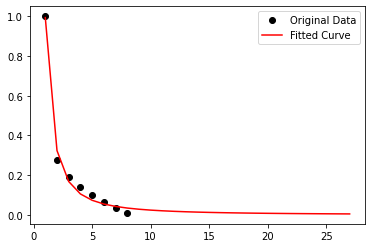

In [45]:
plt.figure()
plt.plot(x, y, 'ko', label="Original Data")
plt.plot(x2, func(x2, *popt), 'r-', label="Fitted Curve")
plt.legend()
plt.show()

In [46]:
# Retention ratio на 6 месяцев вперёд понедельно
retention_ratio_6months = func(x2, *popt)

In [47]:
LTV_weekly = retention_ratio_6months * ARPWAU

In [48]:
# 0 неделя - триал, поэтому зануляю выручку 
LTV_weekly[0] = 0

In [49]:
LTV_forecast = LTV_weekly.cumsum()

In [50]:
# Прогноз, каким будет LTV на полгода
print('Прогноз LTV на полгода, $: ', round(LTV_forecast[-1], 3))

Прогноз LTV на полгода, $:  5.102


## 3. Построить график, который будет отображать кривую фактического LTV на фоне кривой прогнозируемого LTV.

In [51]:
# Фактический LTV
LTV_fact = cumsum_revenue_pivot_nona.sum(axis=0) / unique_users_count_pivot.iloc[:,0].sum()

# Прогнозный LTV
LTV_forecast

array([0.        , 1.61425252, 2.45187873, 2.97776937, 3.34428456,
       3.61716615, 3.8298097 , 4.00113417, 4.14273083, 4.26213403,
       4.36447305, 4.45337232, 4.5314725 , 4.60074744, 4.66270506,
       4.71851909, 4.76911814, 4.81524745, 4.85751274, 4.89641187,
       4.93235823, 4.96569821, 4.99672443, 5.025686  , 5.05279644,
       5.07823989, 5.10217612])

In [52]:
LTV_fact

         weeks_sinse_trial
revenue  0                    0.000714
         1                    1.370904
         2                    2.324976
         3                    3.012926
         4                    3.512727
         5                    3.847303
         6                    4.024109
         7                    4.058693
         8                    4.059010
dtype: float64

In [53]:
LTV_fact[4] - LTV_forecast[4]

0.1684425499478861

In [54]:
x_fact = np.arange(0,9)
x_forecast = np.arange(0,27)

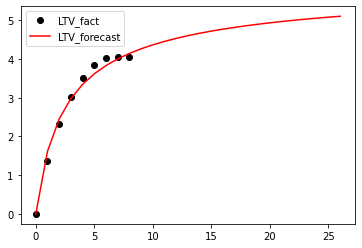

In [55]:
plt.figure()
plt.plot(x_fact, LTV_fact, 'ko', label="LTV_fact")
plt.plot(x_forecast, LTV_forecast, 'r-', label="LTV_forecast")
plt.legend()
plt.show()

## 4. Рассчитать ROMI на 4 недели и на полгода, если стоимость привлечения платящего пользователя 6 USD (ROMI нужно брать операционный, а не бухгалтерский, цель: узнать как окупятся наши инвестиции).

In [56]:
# ROMI = (LTV - CAC) / CAC * 100

In [57]:
CAC = 6

In [58]:
ROMI_4_weeks = (LTV_fact[4] - CAC) / CAC * 100

In [59]:
ROMI_26_weeks = (LTV_forecast[26] - CAC) / CAC * 100

In [60]:
print('ROMI на 4 недели, %: ', round(ROMI_4_weeks, 2))
print('ROMI на 6 месяцев, %: ', round(ROMI_26_weeks, 2))

ROMI на 4 недели, %:  -41.45
ROMI на 6 месяцев, %:  -14.96


# Ответы

In [61]:
# Так как нет вводных данных про Gross Margin и discount rate, считаю LTV через revenue
print('Текущий LTV юзера, $: ', round(LTV_current,3))

Текущий LTV юзера, $:  4.059


In [62]:
# Прогноз, каким будет LTV на полгода
print('Прогноз LTV на полгода, $: ', round(LTV_forecast[-1], 3))

Прогноз LTV на полгода, $:  5.102


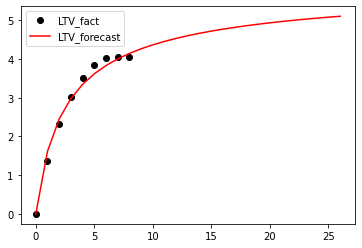

In [66]:
plt.figure()
plt.plot(x_fact, LTV_fact, 'ko', label="LTV_fact")
plt.plot(x_forecast, LTV_forecast, 'r-', label="LTV_forecast")
plt.legend()
plt.show()

In [64]:
print('ROMI на 4 недели, %: ', round(ROMI_4_weeks, 2))
print('ROMI на 6 месяцев, %: ', round(ROMI_26_weeks, 2))

ROMI на 4 недели, %:  -41.45
ROMI на 6 месяцев, %:  -14.96


# Вывод

In [65]:
# Вывод: трафик не окупается за 6 месяцев

# Варианты действий:
# 1. Ждать дольше - не подходит, т.к. прогнозируемый LTV на 1 год < $6
# 2. Увеличивать retention
# 3. Уменьшать CAC